<a href="https://colab.research.google.com/github/dzurel/Mobile-Apps-Games/blob/master/App_Store_XGB_H2O_AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
! apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
openjdk version "11.0.4" 2019-07-16
OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3)
OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)


In [51]:
! pip install h2o

     |████████████████████████████████| 123.7MB 92kB/s 
  Created wheel for h2o: filename=h2o-3.26.0.11-py2.py3-none-any.whl size=123721708 sha256=9676f60a3d956be5518158a9001f87863792f151ed8da6fcf21f9707fcbd99ae
  Stored in directory: /root/.cache/pip/wheels/71/e6/ed/fb9be80ae2eb0bef9deada74fc370b2532f578d8b00bc1a8fb
Successfully built h2o


In this kernel, we'll go over the following topics -

1) Preparing the dataset for regression (i.e. encoding)

2) Using scikit learn's linear regression to predict the rating

3) Using XGBoost to predict the rating

4) Using H2O AutoML to predict rating

### Preparing the dataset for regression
Import the neccessary libraries and the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('https://raw.githubusercontent.com/dzurel/Mobile-Apps-Games/master/appstore_games.csv')
data.head()

,URL,ID,Name,Subtitle,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date
0,https://apps.apple.com/us/app/sudoku/id284921427,284921427,Sudoku,NaN,https://is2-ssl.mzstatic.com/image/thumb/Purpl...,4.0,3553.0,2.99,NaN,"Join over 21,000,000 of our fans and download ...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",15853568.0,Games,"Games, Strategy, Puzzle",11/07/2008,30/05/2017
1,https://apps.apple.com/us/app/reversi/id284926400,284926400,Reversi,NaN,https://is4-ssl.mzstatic.com/image/thumb/Purpl...,3.5,284.0,1.99,NaN,"The classic game of Reversi, also known as Oth...",Kiss The Machine,4+,EN,12328960.0,Games,"Games, Strategy, Board",11/07/2008,17/05/2018
2,https://apps.apple.com/us/app/morocco/id284946595,284946595,Morocco,NaN,https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.0,8376.0,0.00,NaN,Play the classic strategy game Othello (also k...,Bayou Games,4+,EN,674816.0,Games,"Games, Board, Strategy",11/07/2008,5/09/2017
3,https://apps.apple.com/us/app/sudoku-free/id28...,285755462,Sudoku (Free),NaN,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.5,190394.0,0.00,NaN,"Top 100 free app for over a year.\nRated ""Best...",Mighty Mighty Good Games,4+,"DA, NL, EN, FI, FR, DE, IT, JA, KO, NB, PL, PT...",21552128.0,Games,"Games, Strategy, Puzzle",23/07/2008,30/05/2017
4,https://apps.apple.com/us/app/senet-deluxe/id2...,285831220,Senet Deluxe,NaN,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,28.0,2.99,NaN,"""Senet Deluxe - The Ancient Game of Life and A...",RoGame Software,4+,"DA, NL, EN, FR, DE, EL, IT, JA, KO, NO, PT, RU...",34689024.0,Games,"Games, Strategy, Board, Education",18/07/2008,22/07/2018


In [2]:
data.shape

(17007, 18)

Checking for missing values...

In [3]:
data.isna().sum()

URL                                 0
ID                                  0
Name                                0
Subtitle                        11746
Icon URL                            0
Average User Rating              9446
User Rating Count                9446
Price                              24
In-app Purchases                 9324
Description                         0
Developer                           0
Age Rating                          0
Languages                          60
Size                                1
Primary Genre                       0
Genres                              0
Original Release Date               0
Current Version Release Date        0
dtype: int64

Dropping Subtitle column as it has too many null values. We also drop rows that have any null values.

In [4]:
data = data.drop('Subtitle', axis=1)
filtered_data = data.dropna()
filtered_data.shape

(4618, 17)

Check what fields we cannot use right now. Since it is regression, we should only use numbers, and the object fields are not numbers. So we will have to either drop them or convert them to something we can use.

In [5]:
filtered_data.dtypes == 'object'

URL                              True
ID                              False
Name                             True
Icon URL                         True
Average User Rating             False
User Rating Count               False
Price                           False
In-app Purchases                 True
Description                      True
Developer                        True
Age Rating                       True
Languages                        True
Size                            False
Primary Genre                    True
Genres                           True
Original Release Date            True
Current Version Release Date     True
dtype: bool

Let's start with the Genres field.

In [6]:
filtered_data['Genres'].value_counts()

Games, Strategy, Simulation                 194
Games, Simulation, Strategy                 193
Games, Strategy, Action                     172
Games, Strategy                             148
Games, Strategy, Role Playing               140
                                           ... 
Games, Board, Strategy, Reference             1
Games, Books, Adventure, Strategy             1
Reference, Games, Strategy                    1
Games, Strategy, Lifestyle, Role Playing      1
Entertainment, Strategy, Action, Games        1
Name: Genres, Length: 436, dtype: int64

There are primarily two types of encodings used for such type of data -

1) Label Encoding

2) One Hot Encoding

In Label Encoding, we assign each seperate value a particular value. In One Hot Encoding, we create multiple features from one feature (genre) and fill the value with 0 or 1 depending whether that genre is present in the value or not.

Since each entry in the genre column can have multiple genres, we will have to use one hot encoding. Otherwise, after encoding, for example, "Games, Strategy, Word" will be completely different than "Games, Strategy, Role Playing" even though they have two genres in common.

Here we're going to seperate the genres using the ', ' as the delimiter/seperator. You can see that we have split the multiple genres into individual genres that are in a list.

In [7]:
genres = filtered_data['Genres'].str.split(', ')
genres

5        [Games, Entertainment, Strategy, Puzzle]
15                       [Games, Strategy, Board]
16                       [Games, Strategy, Board]
18                      [Games, Puzzle, Strategy]
19       [Games, Strategy, Puzzle, Entertainment]
                           ...                   
16828                   [Games, Puzzle, Strategy]
16842                   [Games, Action, Strategy]
16856               [Games, Simulation, Strategy]
16863                    [Games, Board, Strategy]
16932         [Utilities, Games, Board, Strategy]
Name: Genres, Length: 4618, dtype: object

sklearn's MultiLabelBinarizer makes it very easy to create a multi label dataframe.

In [8]:
from sklearn.preprocessing import MultiLabelBinarizer

# Binarise labels

mlb = MultiLabelBinarizer()
expandedLabelData = mlb.fit_transform(filtered_data['Genres'].str.split(', '))
labelClasses = mlb.classes_
print(labelClasses)

# Create a pandas.DataFrame from our output
expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)
expandedLabels.head()

['Action' 'Adventure' 'Board' 'Books' 'Business' 'Card' 'Casino' 'Casual'
 'Education' 'Entertainment' 'Family' 'Finance' 'Food & Drink' 'Games'
 'Health & Fitness' 'Lifestyle' 'Magazines & Newspapers' 'Medical' 'Music'
 'Navigation' 'News' 'Photo & Video' 'Productivity' 'Puzzle' 'Racing'
 'Reference' 'Role Playing' 'Simulation' 'Social Networking' 'Sports'
 'Strategy' 'Travel' 'Trivia' 'Utilities' 'Word']


,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,Trivia,Utilities,Word
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


Let's see how many of each genre is present.

In [9]:
expandedLabels.sum()

Action                     699
Adventure                  221
Board                      379
Books                        9
Business                     8
Card                       199
Casino                       8
Casual                     314
Education                  117
Entertainment             2312
Family                     207
Finance                     20
Food & Drink                18
Games                     4618
Health & Fitness            11
Lifestyle                   52
Magazines & Newspapers       1
Medical                      3
Music                       29
Navigation                   2
News                         4
Photo & Video                6
Productivity                10
Puzzle                     722
Racing                      31
Reference                   20
Role Playing               622
Simulation                 858
Social Networking           57
Sports                     108
Strategy                  4618
Travel                      29
Trivia  

I'm going to plot them for a more intuitive understanding.

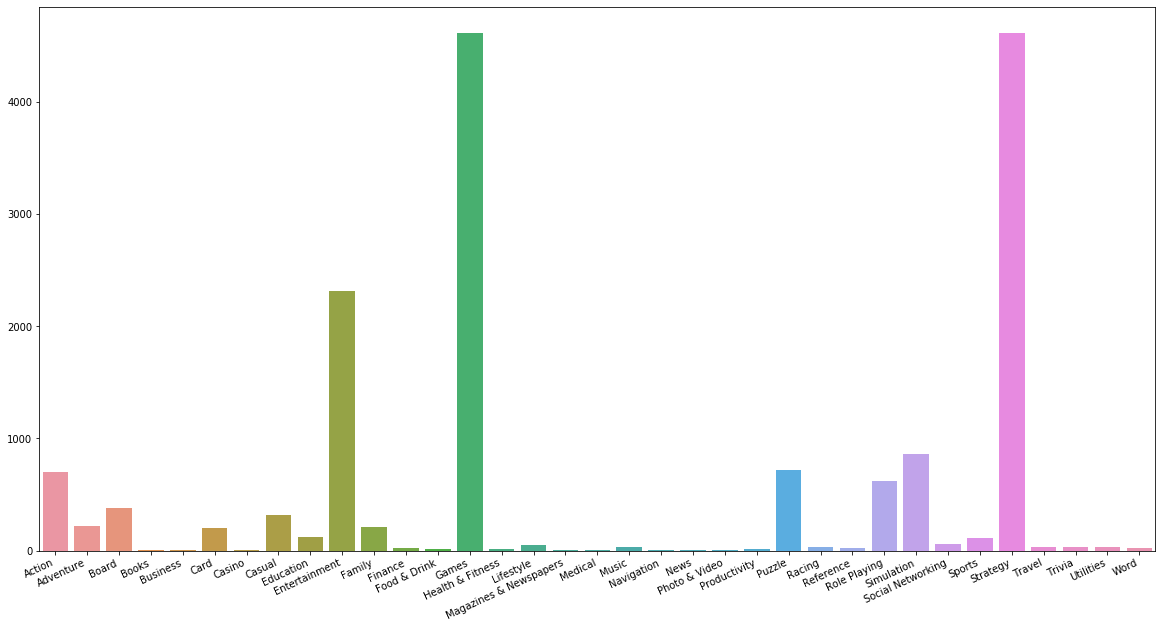

In [10]:
categories = list(expandedLabels.columns.values)
plt.figure(figsize=(20,10))
f = sns.barplot(categories, expandedLabels.sum().values)
f.set_xticklabels(f.get_xticklabels(), rotation='25', ha="right");

Seems like Games and Strategy are the most common genres, which is not surprising because the dataset itself is named 'Mobile Strategy Games'. Let's try removing them and check...

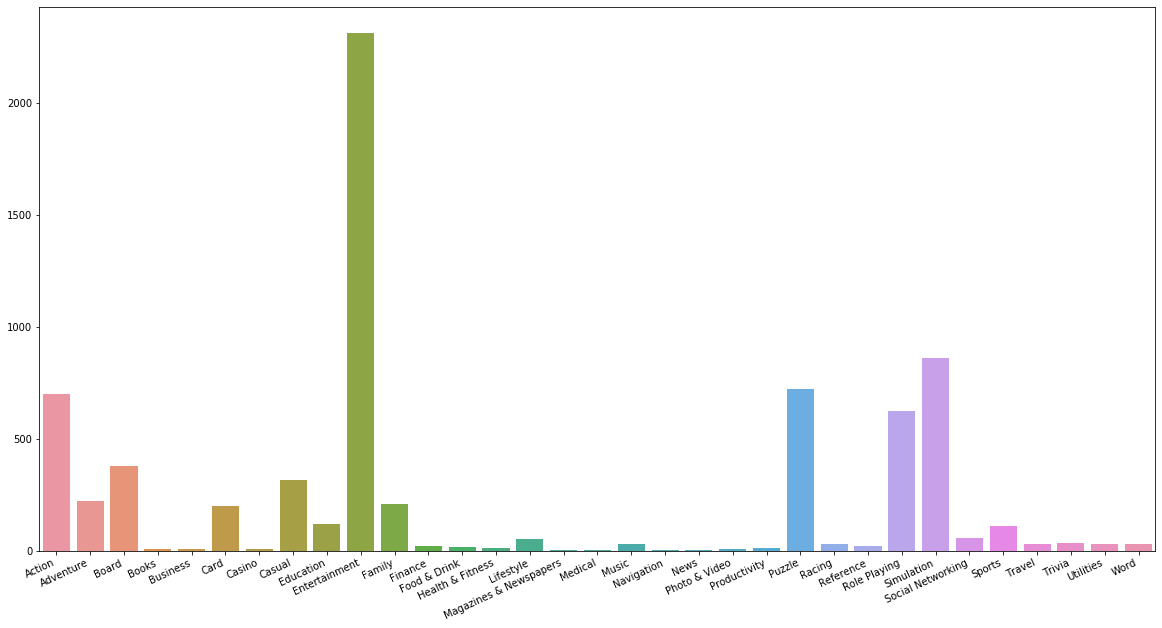

In [11]:
expanded_labels_minus_games_strategy = expandedLabels.drop(["Strategy", "Games"], axis=1)
categories = list(expanded_labels_minus_games_strategy.columns.values)
plt.figure(figsize=(20,10))
f = sns.barplot(categories, expanded_labels_minus_games_strategy.sum().values)
f.set_xticklabels(f.get_xticklabels(), rotation='25', ha="right");

It's quite highly dominated by Entertainment.

We're going to merge the two dataframes -- our filtered data frame with no null values and the expanded label dataframes with a one hot encoded genres. So our new dataframe will have the columns of the original dataframe and the expanded label dataframe.

In [12]:
print(filtered_data.shape)
print(expandedLabels.shape)
df = pd.concat([filtered_data.reset_index(drop=True),expandedLabels.reset_index(drop=True)], axis=1)
print(df.shape)
df.head()

(4618, 17)
(4618, 35)
(4618, 52)


,URL,ID,Name,Icon URL,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,Trivia,Utilities,Word
0,https://apps.apple.com/us/app/sudoku-classic-n...,286210009,Sudoku - Classic number puzzle,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.0,47.0,0.0,1.99,"Sudoku will tease your brain, challenge you or...",OutOfTheBit Ltd,4+,EN,48672768.0,Games,"Games, Entertainment, Strategy, Puzzle",30/07/2008,29/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,https://apps.apple.com/us/app/awele-oware-manc...,289217958,Awele/Oware - Mancala HD,https://is3-ssl.mzstatic.com/image/thumb/Purpl...,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,https://apps.apple.com/us/app/catcha-mouse/id2...,290493286,Catcha Mouse,https://is1-ssl.mzstatic.com/image/thumb/Purpl...,3.5,95971.0,0.0,"1.99, 0.99, 1.99, 0.99, 4.99, 1.99, 1.99",*More than 4 Million downloads!!!\n\n#1 iPhone...,"Meme, Inc",4+,EN,26820692.0,Games,"Games, Puzzle, Strategy",19/02/2009,26/04/2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,https://apps.apple.com/us/app/cool-sudoku-jigs...,290614255,"Cool Sudoku, Jigsaw, Killer",https://is5-ssl.mzstatic.com/image/thumb/Purpl...,3.5,357.0,0.0,"0.99, 0.99, 0.99","You can now play Sudoku, Killer Sudoku, Jigsaw...",Splash Software Ltd.,4+,EN,52236288.0,Games,"Games, Strategy, Puzzle, Entertainment",24/09/2008,26/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


Dropping some columns that we are not going to use... These seem unlikely to affect our classification. These are unique to each game, and unique IDs should not be used for regression as they are different for each reading and often provide no inference.

In [13]:
df = df.drop(['URL', 'ID', 'Icon URL'], axis=1)
df.head()

,Name,Average User Rating,User Rating Count,Price,In-app Purchases,Description,Developer,Age Rating,Languages,Size,Primary Genre,Genres,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,Trivia,Utilities,Word
0,Sudoku - Classic number puzzle,3.0,47.0,0.0,1.99,"Sudoku will tease your brain, challenge you or...",OutOfTheBit Ltd,4+,EN,48672768.0,Games,"Games, Entertainment, Strategy, Puzzle",30/07/2008,29/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,Awele/Oware - Mancala HD,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,Awele/Oware - Mancala HD,3.0,112.0,0.0,0.99,Awele/Oware is the oldest African board game a...,SOLILAB,4+,"EN, FR, DE, IT, ES",122826752.0,Games,"Games, Strategy, Board",31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Catcha Mouse,3.5,95971.0,0.0,"1.99, 0.99, 1.99, 0.99, 4.99, 1.99, 1.99",*More than 4 Million downloads!!!\n\n#1 iPhone...,"Meme, Inc",4+,EN,26820692.0,Games,"Games, Puzzle, Strategy",19/02/2009,26/04/2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,"Cool Sudoku, Jigsaw, Killer",3.5,357.0,0.0,"0.99, 0.99, 0.99","You can now play Sudoku, Killer Sudoku, Jigsaw...",Splash Software Ltd.,4+,EN,52236288.0,Games,"Games, Strategy, Puzzle, Entertainment",24/09/2008,26/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0


We will now proceed to one hot encode the In-app Purchases as well.

In [14]:
df['In-app Purchases'].value_counts()

0.99                                                                390
1.99                                                                249
2.99                                                                205
0.99, 0.99                                                           73
4.99                                                                 68
                                                                   ... 
0.99, 1.99, 4.99, 0.99, 8.99, 18.99, 4.99                             1
1.99, 4.99, 9.99, 0.99, 19.99, 1.99, 7.99, 4.99, 39.99, 79.99         1
4.99, 3.99, 1.99, 9.99, 19.99, 7.99, 0.99, 5.99, 1.99, 2.99           1
19.99, 4.99, 9.99, 2.99, 99.99, 49.99, 2.99, 19.99, 13.99, 99.99      1
9.99, 4.99, 2.99, 0.99, 49.99, 99.99                                  1
Name: In-app Purchases, Length: 2955, dtype: int64

In [15]:
mlb_inapp = MultiLabelBinarizer()
expandedLabelData = mlb_inapp.fit_transform(df['In-app Purchases'].str.split(', '))
labelClasses = mlb_inapp.classes_
print(labelClasses)

# Create a pandas.DataFrame from our output
expandedLabels = pd.DataFrame(expandedLabelData, columns=labelClasses)
expandedLabels.head()

['0' '0.0' '0.99' '1.49' '1.99' '10.99' '109.99' '11.99' '119.99' '12.99'
 '129.99' '13.99' '139.99' '14.99' '15.99' '16.99' '169.99' '17.99'
 '18.99' '19.49' '19.99' '199.99' '2.49' '2.99' '20.99' '21.99' '22.99'
 '23.49' '23.99' '24.99' '25.99' '26.99' '27.99' '28.99' '29.99' '3.49'
 '3.99' '30.99' '31.99' '32.99' '33.99' '34.99' '35.99' '36.99' '37.99'
 '38.99' '39.99' '4.49' '4.99' '40.99' '41.99' '43.99' '44.99' '45.99'
 '46.99' '47.99' '48.99' '49.99' '5.49' '5.99' '54.99' '59.99' '6.99'
 '64.99' '69.99' '7.49' '7.99' '74.99' '79.99' '8.49' '8.99' '84.99'
 '89.99' '9.49' '9.99' '94.99' '99.99']


,0,0.0,0.99,1.49,1.99,10.99,109.99,11.99,119.99,12.99,129.99,13.99,139.99,14.99,15.99,16.99,169.99,17.99,18.99,19.49,19.99,199.99,2.49,2.99,20.99,21.99,22.99,23.49,23.99,24.99,25.99,26.99,27.99,28.99,29.99,3.49,3.99,30.99,31.99,32.99,33.99,34.99,35.99,36.99,37.99,38.99,39.99,4.49,4.99,40.99,41.99,43.99,44.99,45.99,46.99,47.99,48.99,49.99,5.49,5.99,54.99,59.99,6.99,64.99,69.99,7.49,7.99,74.99,79.99,8.49,8.99,84.99,89.99,9.49,9.99,94.99,99.99
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Let's plot the most popular microtransaction costs in mobile games. I'm going to plot only the top 10 microtransactions.

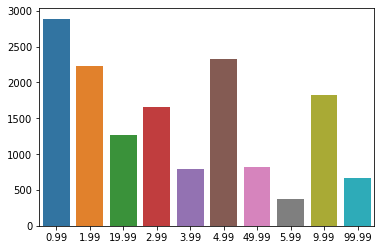

In [16]:
max_10_prices = expandedLabels.sum().sort_values(ascending=False)[:10]
sns.barplot(max_10_prices.index, max_10_prices.values)

 0.99 is the most common, followed by $4.99, $1.99 and $9.99.

Interestly there's also quite a lot of ' 49.99′and‘ 99.99` transactions, so seems like almost (round) numbers like 5, 10, 50,100, etc are more popular.

Now we'll merge the expandedLabels with our dataframe.

In [0]:
df = pd.concat([df.reset_index(drop=True),expandedLabels.reset_index(drop=True)], axis=1)

Finally, since we're going to be predicting the Average User Rating, we'll store it in a seperate variable called y. This is our target.

In [0]:
y = df['Average User Rating']

I'm going to add a new feature -- The lengths of descriptions. It could be that half-hearted devs don't make long descriptions. Or it may not be. We'll see.

In [0]:
desc = df['Description']
desc_lengths = [len(de) for de in desc]
df['desc_lengths'] = desc_lengths

Dropping all irrelevant/already-encoded/target columns...

In [20]:
df = df.drop(['Name', 'Average User Rating', 'In-app Purchases', 'Languages', 'Genres', 'Description'], axis=1)
df.head()

,User Rating Count,Price,Developer,Age Rating,Size,Primary Genre,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,...,31.99,32.99,33.99,34.99,35.99,36.99,37.99,38.99,39.99,4.49,4.99,40.99,41.99,43.99,44.99,45.99,46.99,47.99,48.99,49.99,5.49,5.99,54.99,59.99,6.99,64.99,69.99,7.49,7.99,74.99,79.99,8.49,8.99,84.99,89.99,9.49,9.99,94.99,99.99,desc_lengths
0,47.0,0.0,OutOfTheBit Ltd,4+,48672768.0,Games,30/07/2008,29/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2255
1,112.0,0.0,SOLILAB,4+,122826752.0,Games,31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,618
2,112.0,0.0,SOLILAB,4+,122826752.0,Games,31/08/2008,6/04/2015,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,618
3,95971.0,0.0,"Meme, Inc",4+,26820692.0,Games,19/02/2009,26/04/2013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,794
4,357.0,0.0,Splash Software Ltd.,4+,52236288.0,Games,24/09/2008,26/04/2019,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1039


Our final 2 features are Original Release Date and Current Version Release Date. I'm going to convert them both to the number of days since the dataset was extracted.

But before that, I'm going to make a new category that finds the difference between the current version release date and the original version release date using datetime.

For example, look at the difference between current version release date and the original version release date of the entry at index 1 in our df.

In [21]:
from datetime import datetime
date_format = "%d/%m/%Y"
(datetime.strptime(df['Current Version Release Date'][1], date_format) - datetime.strptime(df['Original Release Date'][1], date_format)).days

2409

That's 2409 days. Seems like this game hasn't been updated in a long time! So this feature could tell us that maybe since the game hasn't been updated, it isn't very popular or good. Logically, it would make more sense for highly rated games to be frequently updated, but this may not be the case. We will see.

Now, Original Release Date and Current Version Release Date will be converted to the number of days since the dataset was extracted. Dataset was extracted on 3rd August, 2019 (from the dataset description).

In [22]:
dataset_date = datetime.strptime("3/7/2019", date_format)
dataset_date

datetime.datetime(2019, 7, 3, 0, 0)

In [0]:
curr_minus_orig = []

for i in range(len(df)):
    curr = df['Current Version Release Date'][i]
    orig = df['Original Release Date'][i]
    diff = datetime.strptime(curr, date_format) - datetime.strptime(orig, date_format)
    curr_minus_orig.append(diff.days)
    

df['Current minus Original'] = np.array(curr_minus_orig)
df['Original Release Date'] = np.array([ (dataset_date - datetime.strptime(date, date_format)).days for date in df['Original Release Date']])
df['Current Version Release Date'] =  np.array([ (dataset_date - datetime.strptime(date, date_format)).days for date in df['Current Version Release Date']])

So we added a new feature called Current minus Original, and converted two existing features (Original Release Date and Current Version Release Date) into number of days since the dataset release.

Now, let's convert the remaining object categories to something that algorithms can use (numbers) using Label Encoding.

In [24]:
df.dtypes[df.dtypes == object]

Developer        object
Age Rating       object
Primary Genre    object
dtype: object

So for example, the age rating column now has the following unique values.

In [25]:
df['Age Rating'].unique()

array(['4+', '9+', '12+', '17+'], dtype=object)

In [0]:
from sklearn import preprocessing
# Label Encoding
for f in df.columns:
    if df[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

After label encoding, the Age Rating column looks like

In [27]:
df['Age Rating'].unique()

array([2, 3, 0, 1])

Now, this makes no sense. 4+ is mapped to 2, 9+ is mapped to 1 but 17+ is mapped to 1. To make the mapping better, we should use our own predefined mapping in this case.

I'm going to convert 4+, 9+, 12+ and 17+ to 4,9, 12 and 17 respectively.

In [28]:
df['Age Rating'][df['Age Rating'] == 2] = 4
df['Age Rating'][df['Age Rating'] == 3] = 9
df['Age Rating'][df['Age Rating'] == 0] = 12
df['Age Rating'][df['Age Rating'] == 1] = 17

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doi

In [29]:
df['Age Rating'].unique()

array([ 4,  9, 12, 17])

We're going to split our dataframe and y to check how well our model generalizes in the future.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=123)

Going to fill the missing values with 0.

In [0]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

In [32]:
X_train.shape

(3694, 122)

Before we proceed with regression, let us check how well distributed the data is.

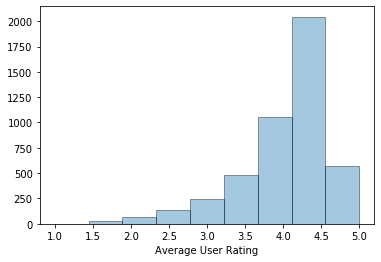

In [33]:
sns.distplot(y, hist=True, kde=False, bins=9, hist_kws={'edgecolor':'#000000'})

Most readings lie between 4.0 and 4.5 in our dataset, which will likely result in most predictions to be between 4.0 and 4.5.

Before we move in to regression, let us take one final look at our dataframes.

In [34]:
X_train.head()

,User Rating Count,Price,Developer,Age Rating,Size,Primary Genre,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,...,32.99,33.99,34.99,35.99,36.99,37.99,38.99,39.99,4.49,4.99,40.99,41.99,43.99,44.99,45.99,46.99,47.99,48.99,49.99,5.49,5.99,54.99,59.99,6.99,64.99,69.99,7.49,7.99,74.99,79.99,8.49,8.99,84.99,89.99,9.49,9.99,94.99,99.99,desc_lengths,Current minus Original
1298,33.0,0.0,520,9,2.470707e+07,5,1841,1841,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,296,0
4431,312.0,0.0,2282,4,1.233213e+08,5,203,-14,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,835,217
3013,648.0,0.0,797,12,1.866854e+09,5,-30,-30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1955,0
3145,225.0,0.0,1572,9,1.555405e+08,5,931,817,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1373,114
1067,15.0,0.0,2419,17,9.589965e+08,5,2044,2035,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2138,9


In [35]:
X_test.head()

,User Rating Count,Price,Developer,Age Rating,Size,Primary Genre,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,...,32.99,33.99,34.99,35.99,36.99,37.99,38.99,39.99,4.49,4.99,40.99,41.99,43.99,44.99,45.99,46.99,47.99,48.99,49.99,5.49,5.99,54.99,59.99,6.99,64.99,69.99,7.49,7.99,74.99,79.99,8.49,8.99,84.99,89.99,9.49,9.99,94.99,99.99,desc_lengths,Current minus Original
3194,23.0,0.00,2451,9,1.001953e+08,5,847,705,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1369,142
3209,7.0,0.00,1963,9,1.527184e+09,5,936,936,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,2846,0
948,1363.0,2.99,890,4,7.288422e+07,5,2120,769,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,987,1351
1843,687.0,0.00,658,12,9.701683e+07,5,1426,41,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,719,1385
1353,6.0,0.00,1535,4,6.935347e+07,5,1991,1991,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,430,0


### Linear Regression with Sklearn
We first normalize the data using sklearn's preprocessing library, then use the LinearRegression class of sklearn to initialize our model. Then we fit the linear regression model to our preprocessed train data and train labels. Finally, we predict the train and the test labels and calculate the RMSE (root mean squared error) score for each.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train_preprocessed = preprocessing.normalize(X_train)
X_test_preprocessed = preprocessing.normalize(X_test)

lin_model = LinearRegression()
lin_model.fit(X_train_preprocessed, y_train)

y_train_predict = lin_model.predict(X_train_preprocessed)

rmse = (np.sqrt(mean_squared_error(y_train, y_train_predict)))

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print("\n")

# model evaluation for testing set
y_test_predict = lin_model.predict(X_test_preprocessed)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))

The model performance for training set
--------------------------------------
RMSE is 0.6298926023435922


The model performance for testing set
--------------------------------------
RMSE is 0.6880589084750911


I'm going to make a dataframe of the actual value vs the predicted value.

In [37]:
error_frame = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': y_test_predict.flatten()})
error_frame.head(10)

,Actual,Predicted
0,4.5,4.136567
1,3.0,4.189650
2,4.5,4.239712
3,4.0,4.148573
4,3.0,4.069042
5,3.0,4.237414
6,4.5,4.399898
7,4.0,4.279491
8,4.5,3.832580
9,5.0,4.167747


Plotting the first 20 comparisons of our error frame...

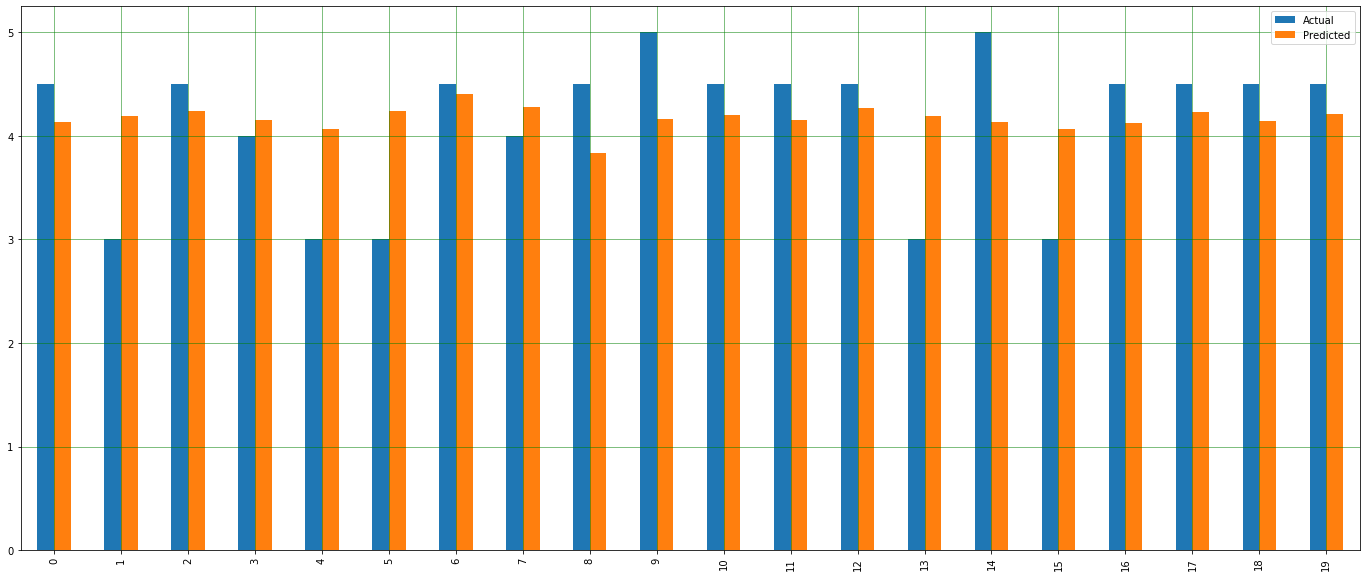

In [38]:
df1 = error_frame[0:20]
df1.plot(kind='bar',figsize=(24,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

A lot of our predictions lie between 4 and 4.5, which is mostly because the dataset majorly had those values. Let us see if XGBoost can give us a lower RMSE than sklearn's linear regression.

### Regression using XGBoost
XGBoost is one of the most popular libraries for using the Gradient Boosting technique. From Wikipedia,

Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of an arbitrary differentiable loss function.

Essentially XGB creates a lot of weak predictors and then combines them to give you a good prediction model. This process of combining predictors/models is called Ensembling.

Import the XGBoost API and create our Regressor with some parameters, then fit it to our data. I picked these parameters quite arbitarily, but after this we will be using GridSearchCV to find better parameters.

Important - the line tree_method='gpu_hist' will throw an error if you are not running a GPU kernel, so you will have to comment that line and run the kernel.

In [39]:
import xgboost as xgb

xgr = xgb.XGBRegressor(           
                 learning_rate=0.05,
                 max_depth=8,
                 min_child_weight=1.5,
                 n_estimators=500,                                                                    
                 seed=42,
                 num_boost_rounds=50,
                 objective="reg:squarederror",
                 tree_method='gpu_hist',  #IMPORTANT. GPU_HIST NEEDS GPU, OTHERWISE ERROR WILL BE THROWN.
                )
xgr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=1.5, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, num_boost_rounds=50,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, silent=None,
             subsample=1, tree_method='gpu_hist', verbosity=1)

Calculating our losses...[RMSE scores]

In [40]:
train_pred = xgr.predict(data= X_train)
test_pred = xgr.predict(data= X_test)

mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

print('RMSE train : {:.3f}'.format(np.sqrt(mse_train)))
print('RMSE test : {:.3f}'.format(np.sqrt(mse_test)))

RMSE train : 0.128
RMSE test : 0.621


Since the RMSE of train is significantly lower than the RMSE of test, we have overfit. Let us try to find better parameters that won't overfit. However, even with overfitting, the 0.621 RMSE is quite a lot better than the 0.688 RMSE of the scikit-learn's linear regressor.

One of the ways of finding ideal hyperparameters is through GridSearchCV, in which we specify the possible each hyperparameter values. GridSearchCV goes through all possible combinations of these parameter values.

In [0]:
from sklearn.model_selection import GridSearchCV

params = {'learning_rate': [0.01, 0.03, 0.06],
          'max_depth' : [4, 6, 8],
          'n_estimators' : [250, 500, 1000, 1500, 2000],
          'num_boost_rounds' : [5, 20],}

So in the above example, since we have 3,3,5,2 possible values (3 for learning_rate, 3 for max_depth, 5 for n_estimators and 2 for num_boost_rounds), we will get 3*3*5*2 = 90 candidates. The best one amongst these will be chosen. If we decide to cross validate them with 3 folds, we will have to fit a total of 90*3 = 270 times.

Here, we will be splitting the training data into 3 instead and then training on two of those, then validating on the one that is left.

I've imported warnings to ignore FutureWarning/Depreciation warnings as they will occur 270 times. Kaggle seems to be using old version of XGBoost where this bug hasn't been fixed, so we will have to ignore them.

We take the scoring as neg_mean_squared_error because by default sklearn assumes that the more mean squared error we have, the better model it is, even though that is not the case here. So since we want to minimize the error, we use neg_mean_squared_error.

The following code will take about 20 minutes to run WITH a GPU. It might take an hour or longer without one. If you want to skip this, comment the following cells until I tell you not to.

In [42]:
%%time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

xgr_optimized = xgb.XGBRegressor(objective="reg:squarederror",
                                 min_child_weight=1.5,
                                 tree_method='gpu_hist')

grid = GridSearchCV(estimator=xgr_optimized, scoring="neg_mean_squared_error", param_grid = params, verbose=1, cv=3)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed: 37.7min finished


CPU times: user 25min 55s, sys: 11min 49s, total: 37min 45s
Wall time: 37min 46s


Finding the best score and the best parameters...

In [43]:
print(grid.best_params_)

{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 250, 'num_boost_rounds': 5}


We'll use the best params as arguments for our XGBRegressor, then fit our training data.

In [44]:
xgr_best = xgb.XGBRegressor(learning_rate = 0.01, max_depth  = 6, n_estimators =  500, num_boost_rounds =  5,  min_child_weight=1.5, tree_method='gpu_hist') #, tree_method='gpu_hist') # You canuncomment this tree method part if you are using GPU

xgr_best.fit(X_train, y_train)

[19:13:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=6, min_child_weight=1.5, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, num_boost_rounds=5, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_hist',
             verbosity=1)

Finally, we will check the RMSE scores.

In [45]:
train_pred = xgr_best.predict(data= X_train)
test_pred = xgr_best.predict(data= X_test)

mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)

print('RMSE train : {:.3f}'.format(np.sqrt(mse_train)))
print('RMSE test : {:.3f}'.format(np.sqrt(mse_test)))

RMSE train : 0.430
RMSE test : 0.610


Even lower! Now, the same thing as we did earlier-- Create an error frame and plot it.

In [46]:
error_frame = pd.DataFrame({'Actual': np.array(y_test).flatten(), 'Predicted': test_pred.flatten()})
error_frame.head(10)

,Actual,Predicted
0,4.5,4.082387
1,3.0,3.668957
2,4.5,4.552275
3,4.0,4.134475
4,3.0,3.811682
5,3.0,4.372706
6,4.5,4.262579
7,4.0,4.270557
8,4.5,4.492755
9,5.0,4.259923


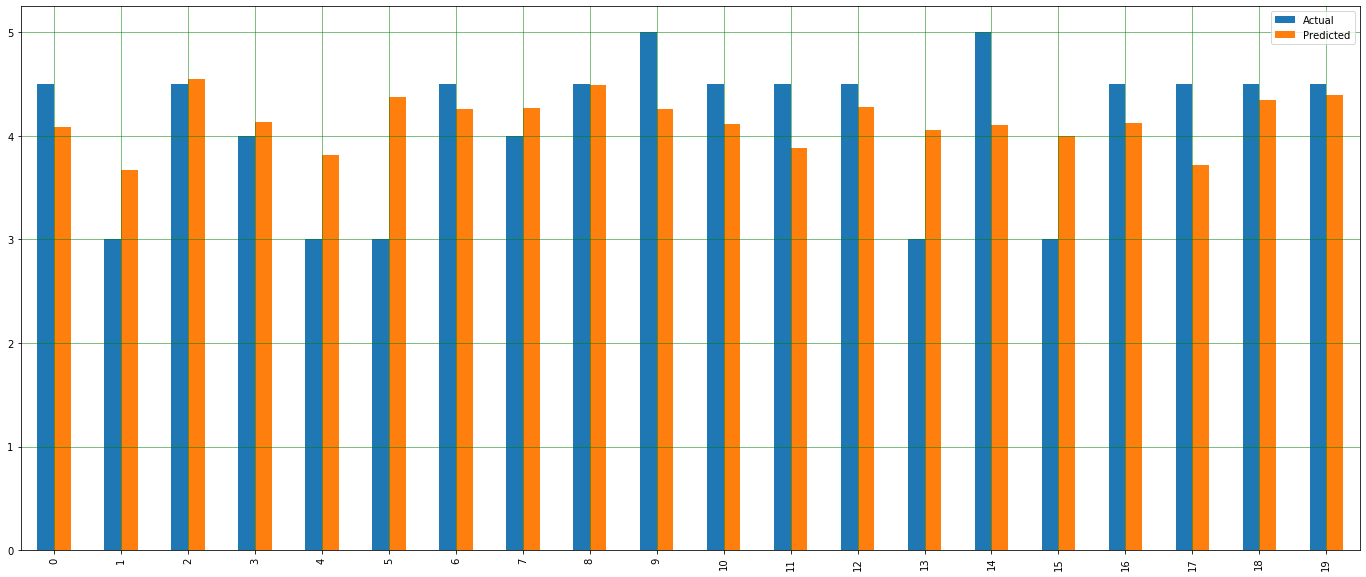

In [47]:
df1 = error_frame[:20]
df1.plot(kind='bar',figsize=(24,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

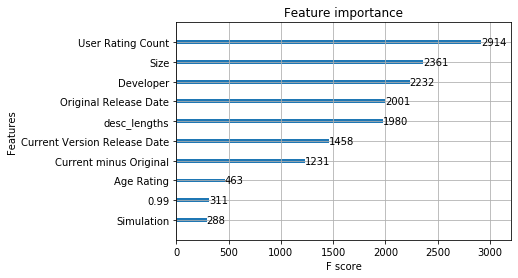

<Figure size 1080x1800 with 0 Axes>

In [48]:
ax = xgb.plot_importance(xgr_best, max_num_features=10)
plt.figure(figsize=(15,25))
plt.show()

Let's look at the most important features. Seems a few features that we inserted turned out to be quite useful - Current minus Original and Description length.

Overall, the linear regression models depends a lot on the user ratings.

In case you are curious about how this feature importance score is obtained (F-score) in XGBoost, these are simply the number of times was this variable split on in all XGBoost trees.

Stop commenting here if you want to skip the hyperoptimization step.
If you want to look at the feature importances and you haven't done hyperoptimization, you can uncomment the following line to look at it.

### H2O AutoML
From H2O's blog:

Automated machine learning (AutoML) is the process of automating the end-to-end process of applying machine learning to real-world problems. AutoML tends to automate the maximum number of steps in an ML pipeline — with a minimum amount of human effort — without compromising the model’s performance.

We don't have to do most of the things in AutoML. Just let it run for a predetermined time, and it will output with (in most cases) an ensembled model that does a very good job of predicting.

Import the h2o library. We will have to initialize the h2o cluster. Since Kaggle kernels are 16GB RAM, I have decided to go with a maximum memory size of 11GB. This will change depending on your machine.

In [52]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='11G')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf83tjpax
  JVM stdout: /tmp/tmpf83tjpax/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf83tjpax/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.11
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_unknownUser_gt3snz
H2O cluster total nodes:,1
H2O cluster free memory:,11 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster status:,"accepting new members, healthy"


Instead of fitting to X_train and y_train like sklearn's fit/predict method, H2O needs to be provided with a H2OFrame (similar to pandas DataFrame but for H2O). In that, the X equivalent to sklearn's y is the column names used for training, and the y equivalent to sklearn's y is the column name used to predict (that is, our target).

In [53]:
X_train['target'] = y_train
h2o_train = h2o.H2OFrame(X_train)

X_test['target'] = y_test
h2o_test = h2o.H2OFrame(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [54]:
h2o_train.head()

User Rating Count,Price,Developer,Age Rating,Size,Primary Genre,Original Release Date,Current Version Release Date,Action,Adventure,Board,Books,Business,Card,Casino,Casual,Education,Entertainment,Family,Finance,Food & Drink,Games,Health & Fitness,Lifestyle,Magazines & Newspapers,Medical,Music,Navigation,News,Photo & Video,Productivity,Puzzle,Racing,Reference,Role Playing,Simulation,Social Networking,Sports,Strategy,Travel,Trivia,Utilities,Word,0,0.0,0.99,1.49,1.99,10.99,109.99,11.99,119.99,12.99,129.99,13.99,139.99,14.99,15.99,16.99,169.99,17.99,18.99,19.49,19.99,199.99,2.49,2.99,20.99,21.99,22.99,23.49,23.99,24.99,25.99,26.99,27.99,28.99,29.99,3.49,3.99,30.99,31.99,32.99,33.99,34.99,35.99,36.99,37.99,38.99,39.99,4.49,4.99,40.99,41.99,43.99,44.99,45.99,46.99,47.99,48.99,49.99,5.49,5.99,54.99,59.99,6.99,64.99,69.99,7.49,7.99,74.99,79.99,8.49,8.99,84.99,89.99,9.49,9.99,94.99,99.99,desc_lengths,Current minus Original,target
33,0,520,9,2.47071e+07,5,1841,1841,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,296,0,4.5
312,0,2282,4,1.23321e+08,5,203,-14,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,835,217,4.5
648,0,797,12,1.86685e+09,5,-30,-30,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1955,0,4.5
225,0,1572,9,1.5554e+08,5,931,817,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1373,114,4.5
15,0,2419,17,9.58996e+08,5,2044,2035,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2138,9,2.5
109,0,474,4,1.17941e+08,5,982,163,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1130,819,4
23601,0,627,12,1.09432e+09,5,897,8,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3558,889,4.5
19,0,1216,4,1.15736e+07,5,2661,2545,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,824,116,3.5
64,0,636,4,1.12996e+08,5,2395,1999,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,726,396,4.5
5,0,593,9,1.98899e+08,5,813,813,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2690,0,4


Set up an H2OAutoML class and specify a max_runtime_secs. I've given it 1200 to make it comparable to the GridSearchCV() we did with XGBoost (that generally takes me about 20 minutes).

Then we train and pass x = column names of features y = column name of the target (it's target here) training_frame = our h2o_train frame validation_frame = our h2o_test frame

In [55]:
aml = H2OAutoML(max_runtime_secs=1200, seed=1)
aml.train(x=list(X_train.columns), y="target", training_frame=h2o_train, validation_frame=h2o_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


Let's look at how the models performed! The leaderboard shows you the best models, sorted from the best to the worst.

In [56]:
lb = aml.leaderboard
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_BestOfFamily_AutoML_20191212_192024,0.336041,0.579691,0.336041,0.417007,0.128836
StackedEnsemble_AllModels_AutoML_20191212_192024,0.336549,0.580129,0.336549,0.417645,0.128876
GBM_grid_1_AutoML_20191212_192024_model_8,0.341609,0.584474,0.341609,0.423087,0.129856
XGBoost_grid_1_AutoML_20191212_192024_model_7,0.343279,0.5859,0.343279,0.423266,0.129677
XGBoost_grid_1_AutoML_20191212_192024_model_2,0.344462,0.586909,0.344462,0.425702,0.130062
XGBoost_grid_1_AutoML_20191212_192024_model_6,0.344827,0.58722,0.344827,0.424036,0.13017
XGBoost_grid_1_AutoML_20191212_192024_model_1,0.345168,0.58751,0.345168,0.424503,0.130213
XGBoost_3_AutoML_20191212_192024,0.345386,0.587696,0.345386,0.425939,0.130238
GBM_3_AutoML_20191212_192024,0.346713,0.588823,0.346713,0.42631,0.130659
XGBoost_grid_1_AutoML_20191212_192024_model_5,0.34743,0.589432,0.34743,0.423604,0.130713


So the best ensemble gave use a rmse of 0.579691, which is a further improvement. The longer you let it run, the better your chance of getting good models, so you can definitely try for longer than 22 minutes.

Finally, we can use the model to predict.

In [57]:
aml.predict(h2o_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict
3.88053
3.75177
4.50791
4.15738
3.90072
4.46506
4.29696
4.26057
4.49809
4.34824


RMSE: 0.68 on linear regression, 0.61 on XGboost, 0.58 on H2O AutoML